# Preamble

In [1]:
%load_ext autoreload

In [2]:
import os
os.chdir('..')
os.path.realpath(os.path.curdir)

'/Users/byronsmith/Projects/strain-corr'

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from lib.pandas_util import idxwhere, align_indexes, invert_mapping
import matplotlib as mpl
import lib.plot
import statsmodels as sm
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
import subprocess
from tempfile import mkstemp
import time
import subprocess

In [4]:
import sfacts as sf

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Analysis Parameters

In [5]:
species_id = '102506'
depth_ratio_bound = 3

# Prepare Data

## Taxonomy

In [9]:
species_taxonomy = pd.read_table('ref/gtpro/species_taxonomy_ext.tsv', names=['genome_id', 'species_id', 'taxonomy_string']).assign(species_id=lambda x: x.species_id.astype(str)).set_index('species_id')[['taxonomy_string']].assign(taxonomy_split=lambda x: x.taxonomy_string.str.split(';'))

for level_name, level_number in [('p__', 1), ('c__', 2), ('o__', 3), ('f__', 4), ('g__', 5), ('s__', 6)]:
    species_taxonomy = species_taxonomy.assign(**{level_name: species_taxonomy.taxonomy_split.apply(lambda x: x[level_number])}) 
species_taxonomy = species_taxonomy.drop(columns=['taxonomy_split'])

species_taxonomy.loc[species_id]

taxonomy_string    d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
p__                                                p__Proteobacteria
c__                                           c__Gammaproteobacteria
o__                                              o__Enterobacterales
f__                                            f__Enterobacteriaceae
g__                                                   g__Escherichia
s__                                                              s__
Name: 102506, dtype: object

## Species

In [10]:
all_species_depth = pd.read_table(f'data/hmp2.a.r.proc.gtpro.species_depth.tsv', index_col=['sample', 'species_id']).squeeze().unstack('species_id', fill_value=0).rename(str, axis='columns')
species_rabund = all_species_depth.divide(all_species_depth.sum(1), axis=0)

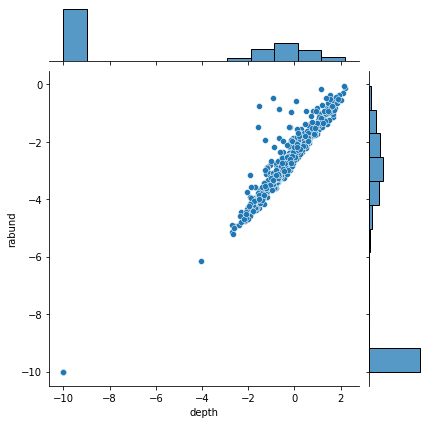

In [11]:
d = pd.DataFrame(dict(depth=np.log10(all_species_depth[species_id] + 1e-10), rabund=np.log10(species_rabund[species_id] + 1e-10)))

sns.jointplot(x='depth', y='rabund', data=d)

In [12]:
species_depth = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.midas_gene75.species_depth.tsv', names=['sample', 'depth'], index_col='sample').squeeze()

In [13]:
species_corr = pd.read_table(f'data_temp/sp-{species_id}.hmp2.a.r.proc.midas_gene75.species_correlation.tsv', names=['sample', 'correlation'], index_col='sample').squeeze()

## Metadata

In [14]:
mgen = pd.read_table('meta/hmp2/mgen.tsv', index_col='library_id')
preparation = pd.read_table('meta/hmp2/preparation.tsv', index_col='preparation_id')
stool = pd.read_table('meta/hmp2/stool.tsv', index_col='stool_id')

sample_meta = mgen.join(preparation, on='preparation_id', rsuffix='_').join(stool, on='stool_id').loc[all_species_depth.index]

In [15]:
len(sample_meta.stool_id.unique()), len(sample_meta.subject_id.unique())

(1305, 106)

## Strains

In [16]:
fit = sf.World.load(
    f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.world.nc'
).drop_low_abundance_strains(0.05)
print(fit.sizes)

np.random.seed(0)
fit_ss = fit.random_sample(position=500)

Frozen({'strain': 110, 'position': 10000, 'sample': 624, 'allele': 2})


/Users/byronsmith/Projects/strain-corr/include/StrainFacts/sfacts/math.py:27: RuntimeWarning: invalid value encountered in float_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))
/Users/byronsmith/Projects/strain-corr/include/StrainFacts/sfacts/math.py:27: RuntimeWarning: invalid value encountered in float_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))


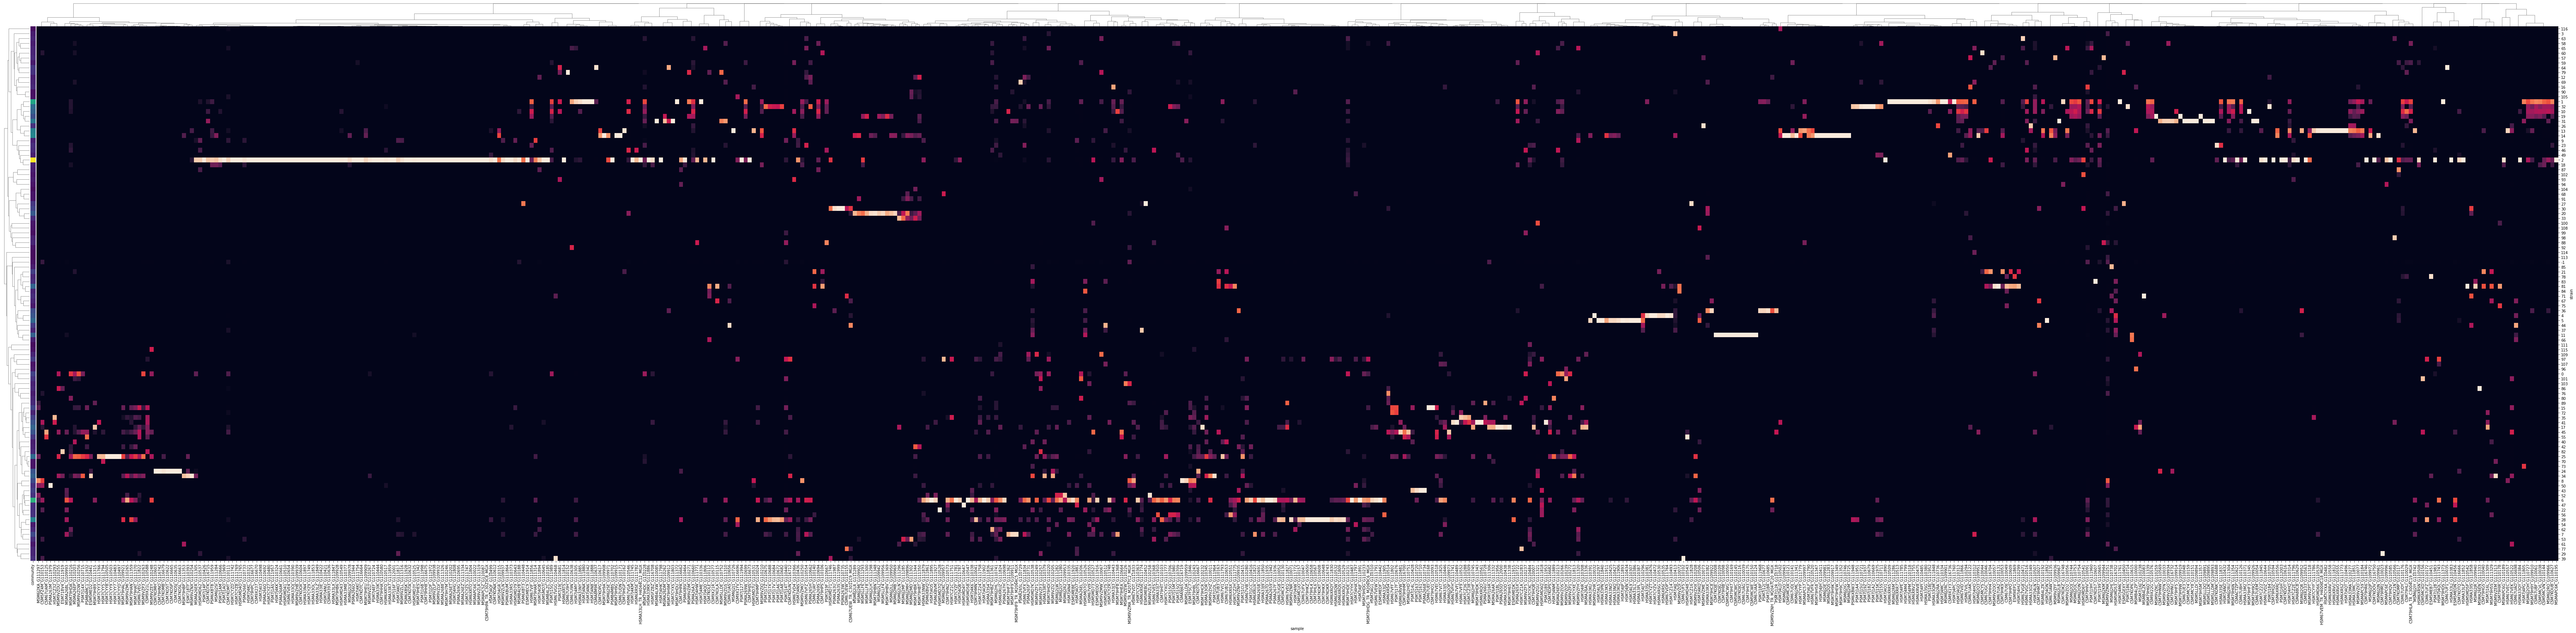

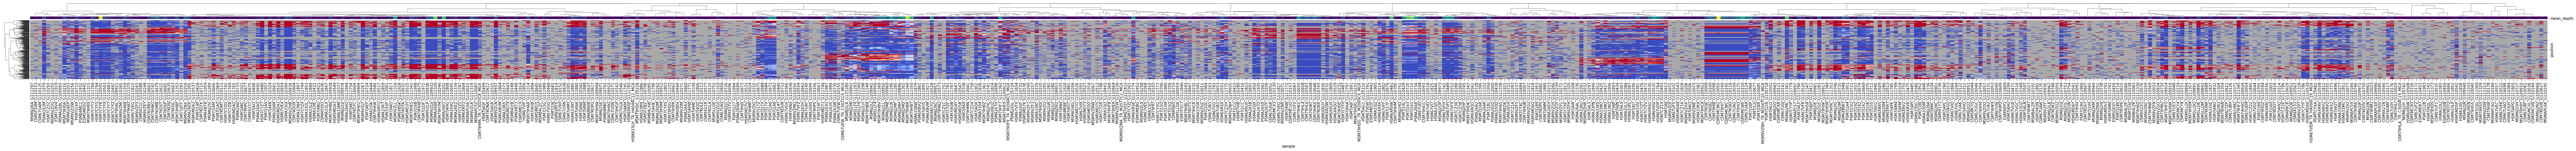

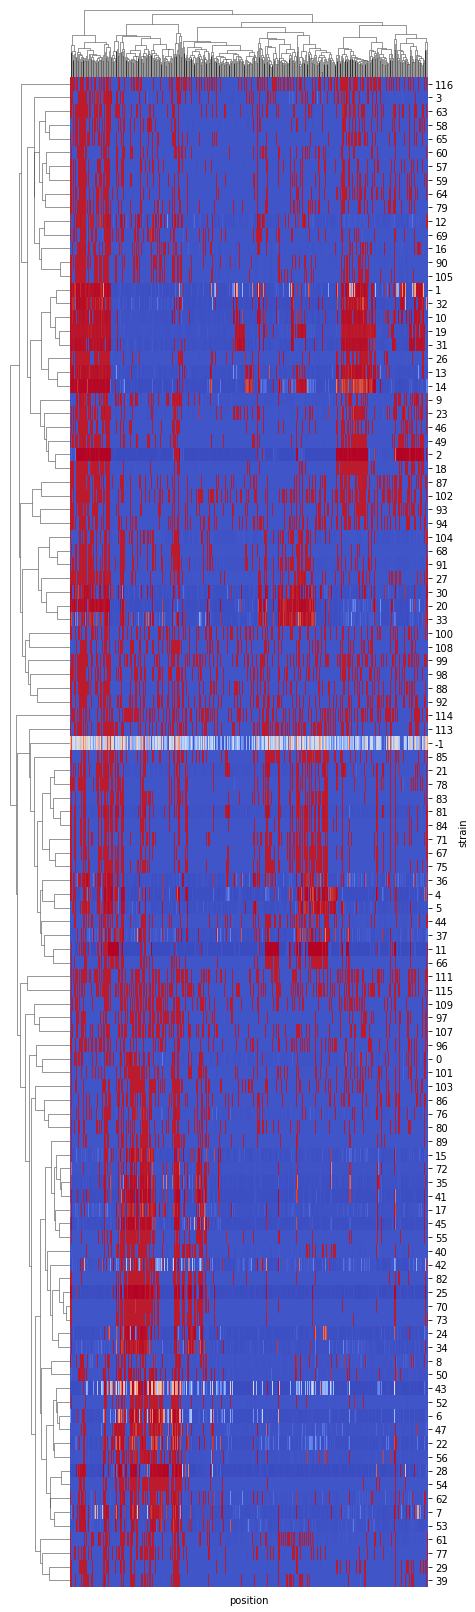

In [17]:
sf.plot.plot_community(
    fit_ss,
    row_linkage_func=lambda w: w.genotype.linkage(),
    col_linkage_func=lambda w: w.metagenotype.linkage(),
)
sf.plot.plot_metagenotype(
    fit_ss,
    col_linkage_func=lambda w: w.metagenotype.linkage(),
    row_linkage_func=lambda w: w.metagenotype.linkage('position'),
)
sf.plot.plot_genotype(
    fit_ss,
    row_linkage_func=lambda w: w.genotype.linkage(),
    col_linkage_func=lambda w: w.metagenotype.linkage('position'),
)

In [18]:
strain_corr = pd.read_table(
    f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.midas_gene75.strain_correlation.tsv',
    index_col=['gene_id', 'strain']
).squeeze().unstack(fill_value=0)
strain_depth = pd.read_table(
    f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.midas_gene75.strain_depth_ratio.tsv',
    index_col=['gene_id', 'strain']
).squeeze().unstack()
strain_corr, strain_depth = align_indexes(*align_indexes(strain_corr, strain_depth), axis="columns")

In [19]:
sample_to_strain = (
    (fit.community.data > 0.95)
    .to_series()
    .unstack()
    .apply(idxwhere, axis=1)
    [lambda x: x.apply(bool)]
    .str[0]
    .rename('strain')
)
    
strain_to_sample_list = (
    sample_to_strain
    .rename('strain_id')
    .reset_index()
    .groupby('strain_id')
    .apply(lambda x: x['sample'].to_list())
)
strain_to_sample_list.apply(len).sort_values(ascending=False).head()

strain_id
2     99
1     20
14    16
31    12
11    11
dtype: int64

In [20]:
strain_thresh = pd.read_table(
    f'data_temp/sp-{species_id}.hmp2.a.r.proc.gtpro.filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts26-s75-seed0.midas_gene75.strain_correlation_threshold.tsv',
    names=['strain_id', 'threshold'],
    index_col='strain_id',
)

## MIDAS Genes, COGs COG categories

In [21]:
gene_cluster = pd.read_table(
    f'ref_temp/midasdb_uhgg/pangenomes/{species_id}/cluster_info.txt'
).set_index('centroid_99', drop=False).rename_axis(index='gene_id')
gene_annotation = pd.read_table(
    'ref_temp/midasdb_uhgg.102506.centroid_75.tsv',
    index_col='locus_tag'
).rename(columns=str.lower)

gene_meta = gene_cluster.loc[gene_cluster.centroid_75.unique()].join(gene_annotation)

In [22]:
_cog_meta = pd.read_table(
    'ref/cog-20.meta.tsv',
    names=['cog', 'categories', 'description', 'gene', 'pathway', '_1', '_2'],
    index_col=['cog']
)
cog_meta = _cog_meta.drop(columns=['categories', '_1', '_2'])
cog_x_category = _cog_meta.categories.apply(tuple).apply(pd.Series).unstack().to_frame(name='category').reset_index()[['cog', 'category']].dropna()

In [23]:
cog_category = pd.read_table('ref/cog-20.categories.tsv', names=['category', 'description'], index_col='category')

## Genes

In [24]:
sample_depth = xr.load_dataarray(f'data_temp/sp-{species_id}.hmp2.a.r.proc.midas_gene75.depth.nc')

# QC Strains

In [25]:
strain_meta = (
    strain_thresh
    .join(fit.genotype.entropy().to_series().rename('genotype_entropy'))
    .join(fit.metagenotype.entropy().to_series().rename('metagenotype_entropy').groupby(sample_to_strain).mean().rename(int))
    .join(strain_to_sample_list.apply(len).rename('num_samples'))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).std().rename('depth_stdev').rename(int))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).max().rename('depth_max').rename(int))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).sum().rename('depth_sum').rename(int))
    .assign(power_index=lambda x: x.depth_stdev * np.sqrt(x.num_samples))
)
strain_meta.sort_values('power_index', ascending=False)

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


,threshold,genotype_entropy,metagenotype_entropy,num_samples,depth_stdev,depth_max,depth_sum,power_index
strain_id,,,,,,,,
2,0.937979,0.053481,0.002659,99,0.970929,5.815871,117.618873,9.660619
14,0.960818,0.133601,0.010753,16,1.329881,5.740450,22.361258,5.319526
25,0.995420,0.052893,0.000780,4,2.290542,6.440463,12.175411,4.581084
11,0.993650,0.049607,0.001486,11,1.253918,7.103562,42.644315,4.158774
4,0.990253,0.114657,0.041987,5,1.343433,4.042929,11.112232,3.004009
6,0.963396,0.159513,0.017053,9,0.848382,2.828063,15.772263,2.545145
1,0.892892,0.162809,0.002950,20,0.500858,2.422547,23.772062,2.239906
31,0.905097,0.111861,0.001198,12,0.628241,2.367712,13.764872,2.176291
17,0.965109,0.138536,0.046516,3,1.215397,3.120490,5.261219,2.105130


/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_2080/1275966379.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.kdeplot(np.log10(strain_depth[species_corr > 0.95][strain] + pseudo), label=strain)
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_2080/1275966379.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.kdeplot(np.log10(strain_depth[species_corr > 0.95][strain] + pseudo), label=strain)
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_2080/1275966379.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.kdeplot(np.log10(strain_depth[species_corr > 0.95][strain] + pseudo), label=strain)
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_2080/1275966379.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.kdeplot(np.log10(strain_depth[species_corr > 0.95][strain] + pseudo), label=strain)
/var/folders

(-3.0, 3.0)

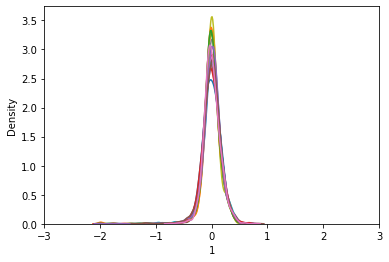

In [26]:
pseudo = 1e-2

for strain in strain_meta.index:
    sns.kdeplot(np.log10(strain_depth[species_corr > 0.95][strain] + pseudo), label=strain)

plt.xlim(-3, 3)

(-3.0, 3.0)

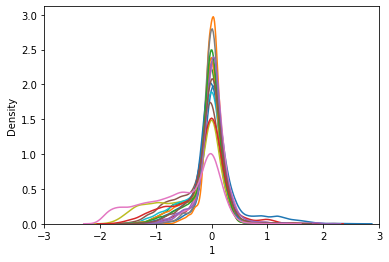

In [27]:
pseudo = 1e-2

for strain in strain_meta.index:
    sns.kdeplot(np.log10(strain_depth[strain_corr[strain_meta.index] > strain_meta.threshold][strain] + pseudo), label=strain)

plt.xlim(-3, 3)

/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_2080/150687423.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = np.log10(strain_depth[species_corr > 0.95].quantile(qq)[strain])
/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


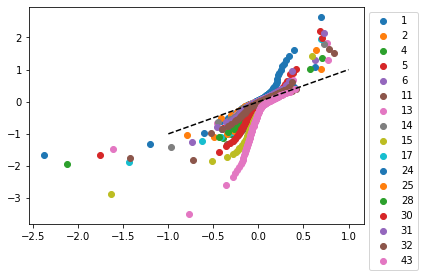

In [28]:

for strain in strain_meta.index:
    qq = np.linspace(0, 1, num=100)
    x = np.log10(strain_depth[species_corr > 0.95].quantile(qq)[strain])
    y = np.log10(strain_depth[strain_corr[strain_meta.index] > strain_meta.threshold].quantile(qq)[strain])
    plt.scatter(x, y, label=strain)

plt.plot([-1, 1], [-1, 1], linestyle='--', color='k')
plt.legend(bbox_to_anchor=(1, 1))

# Enrichment Analysis

In [29]:
corr_hit = strain_corr > strain_meta.threshold
corr_medium_hit = (1 - strain_corr) < (1.5 * (1 - strain_meta.threshold))
strict_depth_hit = (strain_depth < (depth_ratio_bound / 2)) & (strain_depth > 1 / (2 * depth_ratio_bound))
depth_hit = (strain_depth < depth_ratio_bound) & (strain_depth > 1 / depth_ratio_bound)
low_depth = strain_depth < (1 / depth_ratio_bound)
high_depth = strain_depth > depth_ratio_bound
highest_confidence_hit = strict_depth_hit & corr_hit
high_confidence_hit = depth_hit & corr_hit
medium_confidence_hit = depth_hit & corr_medium_hit

ambiguous_hit = depth_hit ^ corr_hit
high_confidence_not_hit = low_depth & ~corr_medium_hit
high_depth_hit = corr_hit & high_depth

/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_2080/2022069649.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  corr_hit = strain_corr > strain_meta.threshold
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_2080/2022069649.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  corr_medium_hit = (1 - strain_corr) < (1.5 * (1 - strain_meta.threshold))


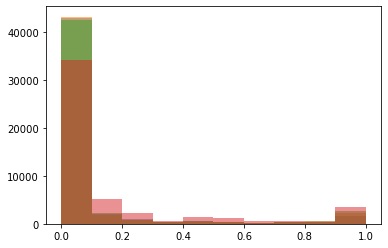

In [30]:
bins = np.linspace(0, 1, num=11)

plt.hist(highest_confidence_hit.mean(1), bins=bins, alpha=0.5)
plt.hist(high_confidence_hit.mean(1), bins=bins, alpha=0.5)
plt.hist(medium_confidence_hit.mean(1), bins=bins, alpha=0.5)
plt.hist(1 - high_confidence_not_hit.mean(1), bins=bins, alpha=0.5)

# plt.yscale('log')

None

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


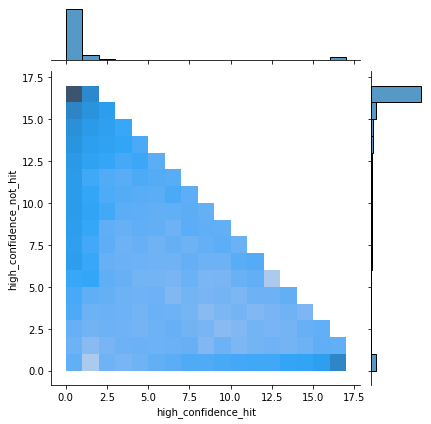

In [31]:
d = pd.DataFrame(dict(high_confidence_hit = high_confidence_hit.sum(1),
                      high_confidence_not_hit = high_confidence_not_hit.sum(1)
                     ))
_max = high_confidence_hit.shape[1]

sns.jointplot(
    'high_confidence_hit',
    'high_confidence_not_hit',
    data=d,
    kind='hist',
    bins=(_max, _max),
    norm=mpl.colors.PowerNorm(1/5),
    vmin=None,
    vmax=None,
)

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


2642 2030

tRNA modification                           32
TCA cycle                                   16
Ribosome 50S subunit                        15
Aminoacyl-tRNA synthetases                  14
Fatty acid biosynthesis                     14
Isoleucine, leucine, valine biosynthesis    13
Aromatic amino acid biosynthesis            12
16S rRNA modification                       12
Menaquinone biosynthesis                    12
Heme biosynthesis                           12
Name: pathway, dtype: int64

hypothetical protein                              612
Vitamin B12 import ATP-binding protein BtuD        30
putative protein                                    6
HTH-type transcriptional regulator HdfR             5
HTH-type transcriptional repressor NanR             5
HTH-type transcriptional activator RhaS             4
p-hydroxybenzoic acid efflux pump subunit AaeA      4
L-threonine 3-dehydrogenase                         4
Periplasmic nitrate reductase                       4
HTH-

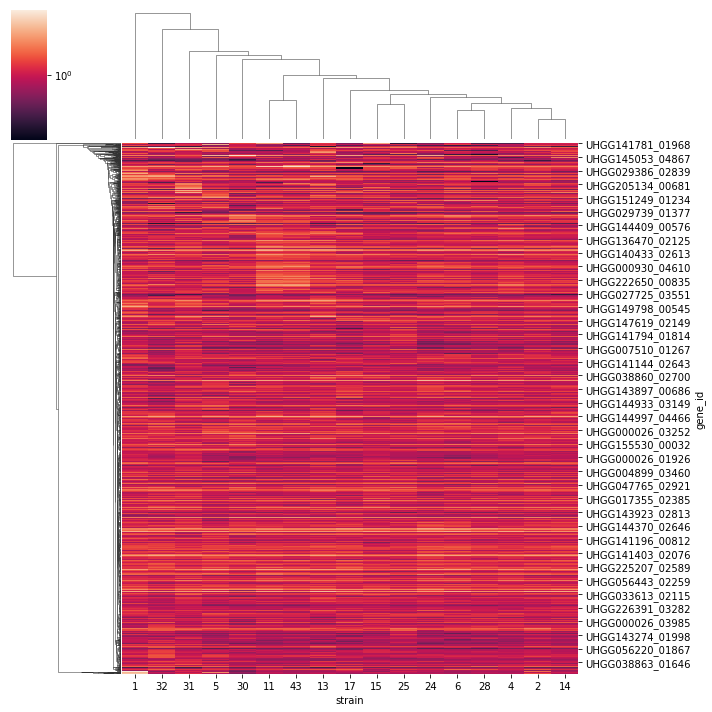

In [32]:
genes_list = idxwhere((high_confidence_hit.mean(1) > 0.8) & (high_confidence_not_hit.mean(1) < 0.05))
d = strain_depth.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[genes_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[genes_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[genes_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


2970 2158

tRNA modification                           33
Ribosome 50S subunit                        19
TCA cycle                                   16
Fatty acid biosynthesis                     15
Aminoacyl-tRNA synthetases                  15
Isoleucine, leucine, valine biosynthesis    13
Glycolysis                                  12
Heme biosynthesis                           12
Menaquinone biosynthesis                    12
23S rRNA modification                       12
Name: pathway, dtype: int64

hypothetical protein                              812
Vitamin B12 import ATP-binding protein BtuD        31
putative protein                                    6
HTH-type transcriptional activator RhaS             5
HTH-type transcriptional regulator HdfR             5
HTH-type transcriptional repressor NanR             5
p-hydroxybenzoic acid efflux pump subunit AaeA      4
Regulator of RpoS                                   4
L-threonine 3-dehydrogenase                         4
Peri

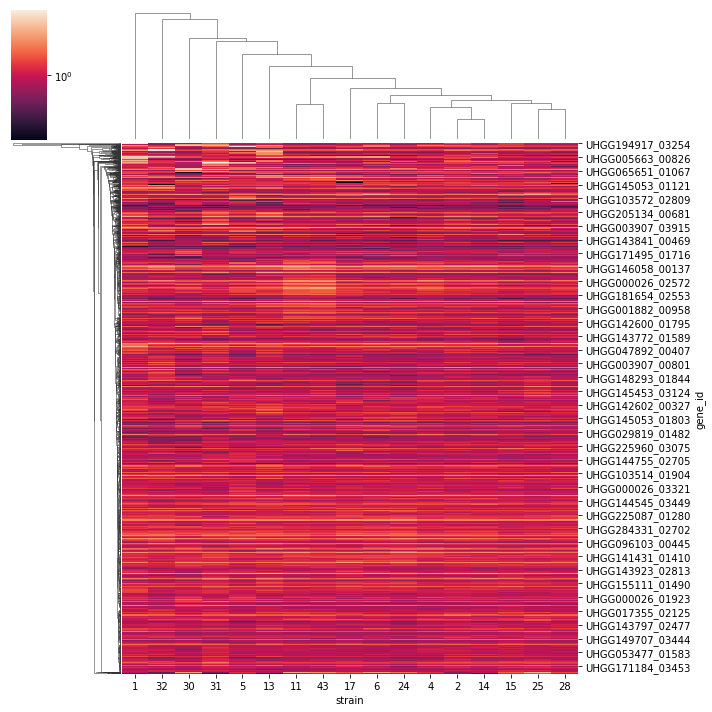

In [33]:
genes_list = idxwhere((medium_confidence_hit.mean(1) > 0.8) & (high_confidence_not_hit.mean(1) < 0.05))
d = strain_depth.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[genes_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[genes_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[genes_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


4996 1480

Fatty acid biosynthesis                        13
Non-phosphorylated Entner-Doudoroff pathway     8
tRNA modification                               7
Cobalamine/B12 biosynthesis                     7
Glycolysis                                      7
FoF1-type ATP synthase                          6
Aromatic amino acid biosynthesis                5
Ribosome 50S subunit                            5
Isoleucine, leucine, valine biosynthesis        5
Lysine biosynthesis                             5
Name: pathway, dtype: int64

hypothetical protein                          3516
Tyrosine recombinase XerC                       27
Prophage integrase IntA                         21
Prophage integrase IntS                         13
D-inositol-3-phosphate glycosyltransferase      11
putative protein YfcO                            9
DNA-invertase hin                                8
dTDP-4-dehydrorhamnose 3,5-epimerase             7
UDP-glucose 4-epimerase                          7
L

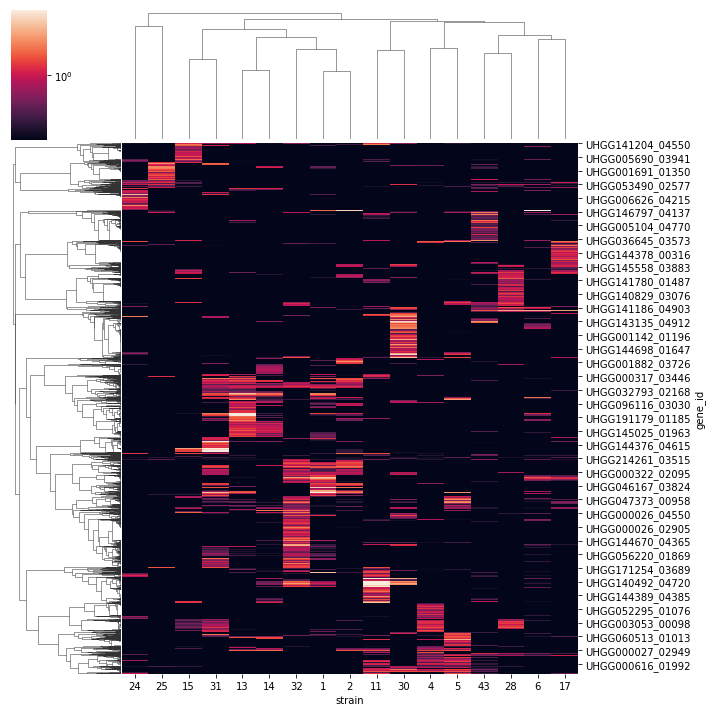

In [34]:
genes_list = idxwhere((high_confidence_hit.mean(1) > 0.05) & (high_confidence_not_hit.mean(1) > 0.6))
d = strain_depth.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[genes_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[genes_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[genes_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


6048 1806

Fatty acid biosynthesis                        16
tRNA modification                              11
Glycolysis                                     10
Non-phosphorylated Entner-Doudoroff pathway     9
Arginine biosynthesis                           9
Ribosome 50S subunit                            8
Aromatic amino acid biosynthesis                8
Cobalamine/B12 biosynthesis                     7
Aminoacyl-tRNA synthetases                      7
RNA polymerase                                  7
Name: pathway, dtype: int64

hypothetical protein                           4242
Tyrosine recombinase XerC                        29
Prophage integrase IntA                          23
Prophage integrase IntS                          13
D-inositol-3-phosphate glycosyltransferase       11
DNA-invertase hin                                 9
Vitamin B12 import ATP-binding protein BtuD       9
putative protein YfcO                             9
dTDP-4-dehydrorhamnose 3,5-epimerase        

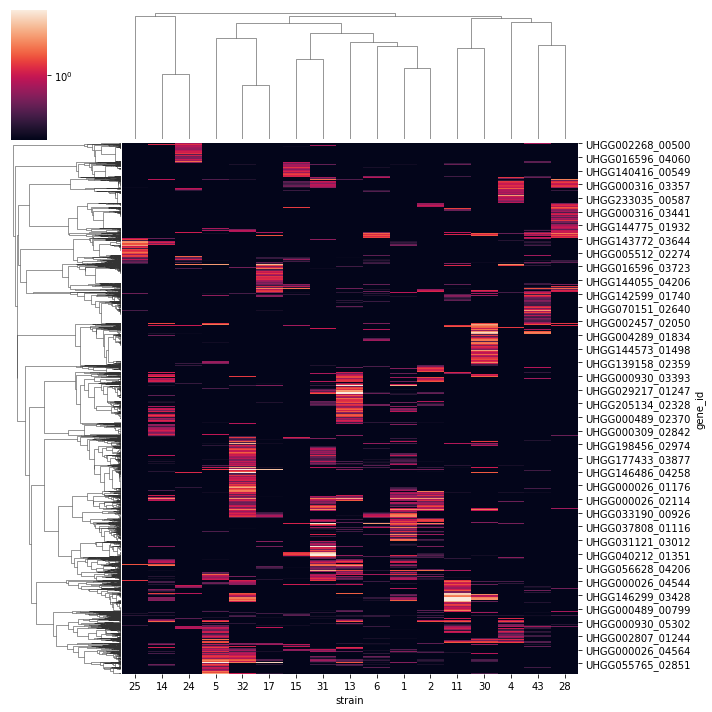

In [35]:
genes_list = idxwhere((medium_confidence_hit.mean(1) > 0.05) & (high_confidence_not_hit.mean(1) > 0.6))
d = strain_depth.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[genes_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[genes_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[genes_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

# Enrichment Analysis using Depth-only Selection

## Standard Depth Ratio

In [36]:
low_depth_hit = (strain_depth < 1 / depth_ratio_bound)

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


3558 2389

tRNA modification                           34
Ribosome 50S subunit                        21
TCA cycle                                   17
Aminoacyl-tRNA synthetases                  15
Fatty acid biosynthesis                     15
Glycolysis                                  14
Isoleucine, leucine, valine biosynthesis    13
Aromatic amino acid biosynthesis            12
Menaquinone biosynthesis                    12
23S rRNA modification                       12
Name: pathway, dtype: int64

hypothetical protein                           1169
Vitamin B12 import ATP-binding protein BtuD      34
putative protein                                  7
L-threonine 3-dehydrogenase                       6
HTH-type transcriptional repressor NanR           6
HTH-type transcriptional regulator HdfR           5
HTH-type transcriptional activator RhaS           5
Sialic acid transporter NanT                      5
Regulator of RpoS                                 4
HTH-type transcription

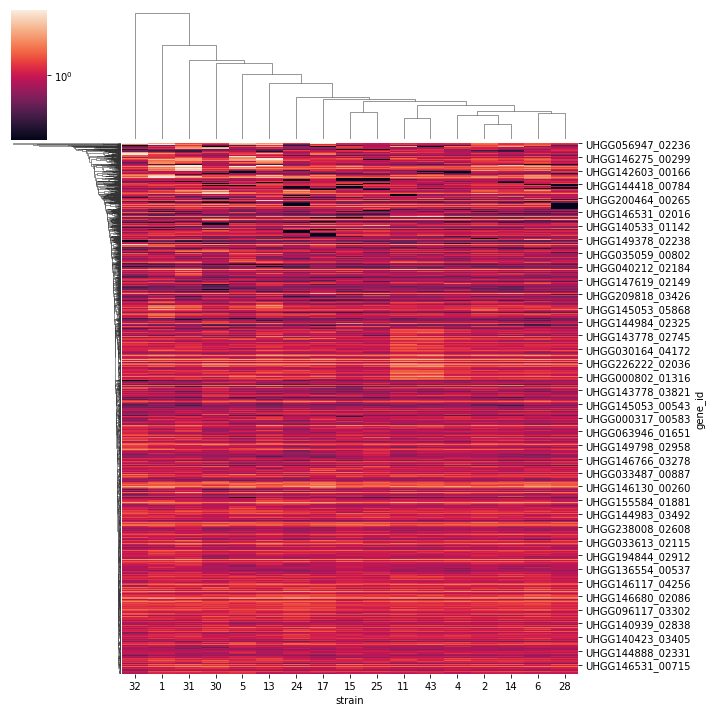

In [37]:
genes_list = idxwhere((depth_hit.mean(1) > 0.8))
d = strain_depth.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[genes_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[genes_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[genes_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


12438 4114

tRNA modification                              32
Aromatic amino acid biosynthesis               26
Fatty acid biosynthesis                        26
Glycolysis                                     23
TCA cycle                                      20
Heme biosynthesis                              20
Arginine biosynthesis                          19
Non-phosphorylated Entner-Doudoroff pathway    19
Pyruvate oxidation                             17
Cobalamine/B12 biosynthesis                    17
Name: pathway, dtype: int64

hypothetical protein                           8324
Tyrosine recombinase XerC                        48
Prophage integrase IntA                          33
D-inositol-3-phosphate glycosyltransferase       18
Vitamin B12 import ATP-binding protein BtuD      15
Prophage integrase IntS                          15
DNA-invertase hin                                14
putative protein                                 14
Adaptive-response sensory-kinase SasA      

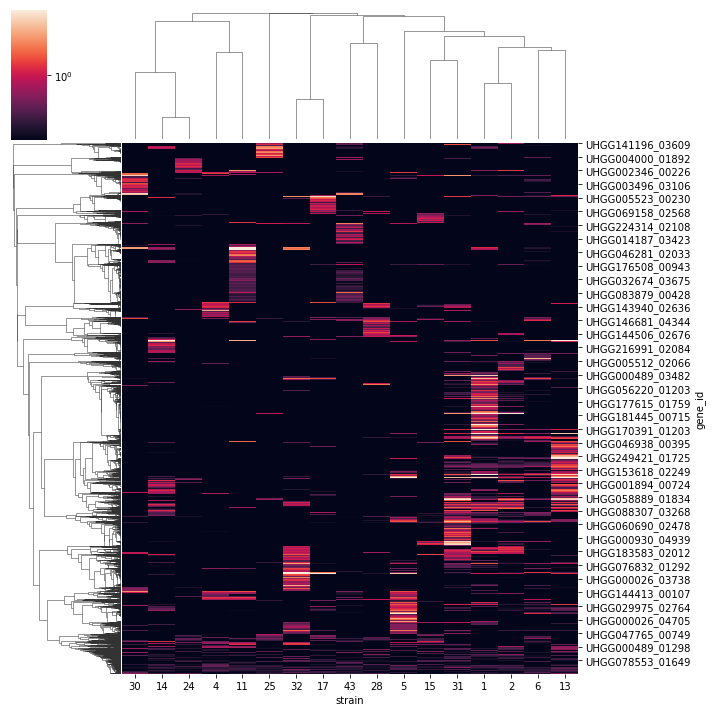

In [38]:
genes_list = idxwhere((depth_hit.mean(1) > 0.05) & (low_depth_hit.mean(1) > 0.6))

d = strain_depth.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[genes_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[genes_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[genes_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

## Deepest Sample

In [39]:
strain_to_max_depth_sample = sample_to_strain.to_frame('strain').join(species_depth).groupby('strain').depth.idxmax().loc[strain_meta.index]
strain_to_max_depth_sample

strain_id
1     HSMA33SG_G110380
2     MSMA2688_G111326
4     HSM67VDP_G111764
5     HSMA33PL_G110387
6     HSM7CYZF_G111781
11    CSM5MCWG_G110050
13    HSM6XRRV_G110558
14    MSM6J2ML_G111341
15    CSM67UEI_G110168
17    PSM7J1BL_G111956
24    CSM7KOMB_G116679
25    HSM7CYYB_G110505
28    CSM79HKZ_G110650
30    PSMA263S_G111999
31    MSM5LLDK_G109895
32    PSM7J1A2_G110669
43    PSM7J161_G110710
Name: depth, dtype: object

In [40]:
strain_depth2 = (sample_depth.sel(sample=strain_to_max_depth_sample.to_list()) / species_depth.loc[strain_to_max_depth_sample].to_xarray()).to_series().unstack('sample').rename(columns=sample_to_strain)

depth2_hit = (strain_depth2 < depth_ratio_bound) & (strain_depth2 > 1 / depth_ratio_bound)
low_depth2_hit = (strain_depth2 < 1 / depth_ratio_bound)
high_depth2_hit = (strain_depth2 > depth_ratio_bound)

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


3506 2400

tRNA modification                           34
Ribosome 50S subunit                        20
Aminoacyl-tRNA synthetases                  17
TCA cycle                                   17
Fatty acid biosynthesis                     15
Glycolysis                                  14
Isoleucine, leucine, valine biosynthesis    14
23S rRNA modification                       12
Menaquinone biosynthesis                    12
Purine biosynthesis                         12
Name: pathway, dtype: int64

hypothetical protein                           1106
Vitamin B12 import ATP-binding protein BtuD      36
putative protein                                  7
HTH-type transcriptional repressor NanR           6
L-threonine 3-dehydrogenase                       6
HTH-type transcriptional regulator HdfR           5
Sialic acid transporter NanT                      5
HTH-type transcriptional activator RhaS           5
Glucitol operon repressor                         4
Putrescine transporter

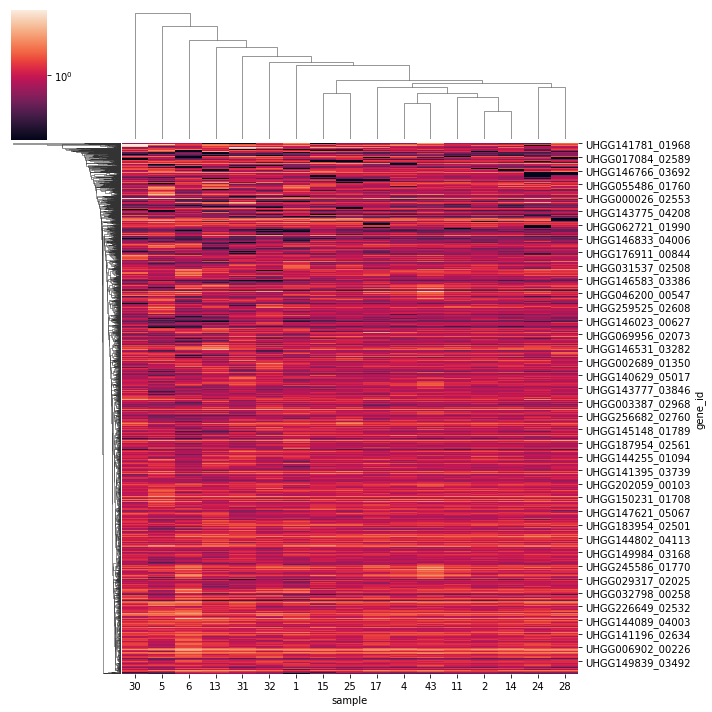

In [41]:
genes_list = idxwhere((depth2_hit.mean(1) > 0.8))
d = strain_depth2.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[genes_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[genes_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[genes_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


12094 3856

tRNA modification                              38
Fatty acid biosynthesis                        25
TCA cycle                                      19
Arginine biosynthesis                          18
Ribosome 50S subunit                           18
Aromatic amino acid biosynthesis               18
Purine biosynthesis                            17
Glycolysis                                     17
Heme biosynthesis                              16
Non-phosphorylated Entner-Doudoroff pathway    14
Name: pathway, dtype: int64

hypothetical protein                           8238
Tyrosine recombinase XerC                        49
Prophage integrase IntA                          34
Vitamin B12 import ATP-binding protein BtuD      16
Prophage integrase IntS                          15
D-inositol-3-phosphate glycosyltransferase       15
Sensor histidine kinase RcsC                     14
LexA repressor                                   12
HTH-type transcriptional activator RhaR    

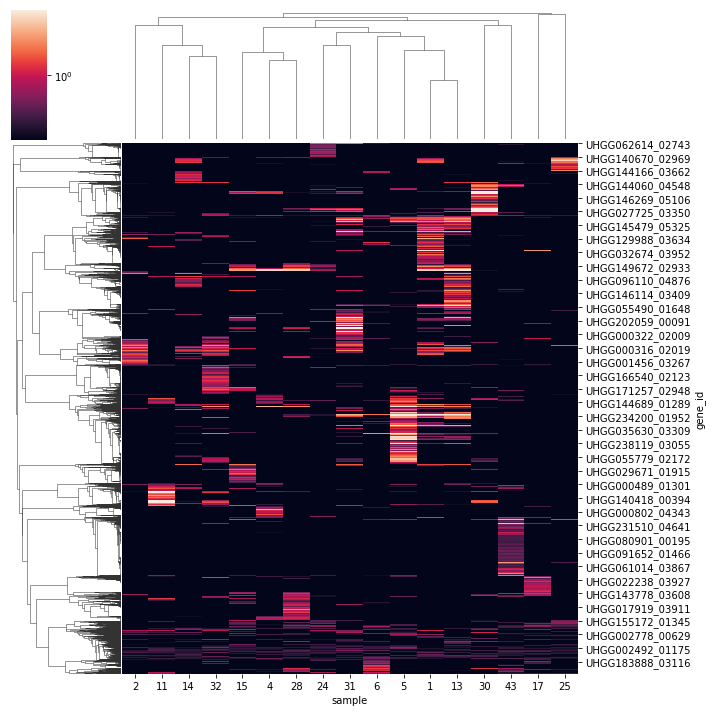

In [42]:
genes_list = idxwhere((depth2_hit.mean(1) > 0.05) & (low_depth2_hit.mean(1) > 0.6))

d = strain_depth2.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[genes_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[genes_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[genes_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

## Sum All Samples

In [43]:
strain_depth3 = (sample_depth.sel(sample=sample_to_strain.index).groupby(sample_to_strain.to_xarray()).sum() / species_depth.groupby(sample_to_strain).sum().rename(int).to_xarray()).sel(strain=strain_meta.index).to_series().unstack('strain')

depth3_hit = (strain_depth3 < depth_ratio_bound) & (strain_depth3 > 1 / depth_ratio_bound)
low_depth3_hit = (strain_depth3 < 1 / depth_ratio_bound)
high_depth3_hit = (strain_depth3 > depth_ratio_bound)

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


3558 2389

tRNA modification                           34
Ribosome 50S subunit                        21
TCA cycle                                   17
Aminoacyl-tRNA synthetases                  15
Fatty acid biosynthesis                     15
Glycolysis                                  14
Isoleucine, leucine, valine biosynthesis    13
Pyrimidine salvage                          12
23S rRNA modification                       12
Menaquinone biosynthesis                    12
Name: pathway, dtype: int64

hypothetical protein                              1169
Vitamin B12 import ATP-binding protein BtuD         34
putative protein                                     7
HTH-type transcriptional repressor NanR              6
L-threonine 3-dehydrogenase                          6
HTH-type transcriptional regulator HdfR              5
HTH-type transcriptional activator RhaS              5
Sialic acid transporter NanT                         5
p-hydroxybenzoic acid efflux pump subunit AaeA    

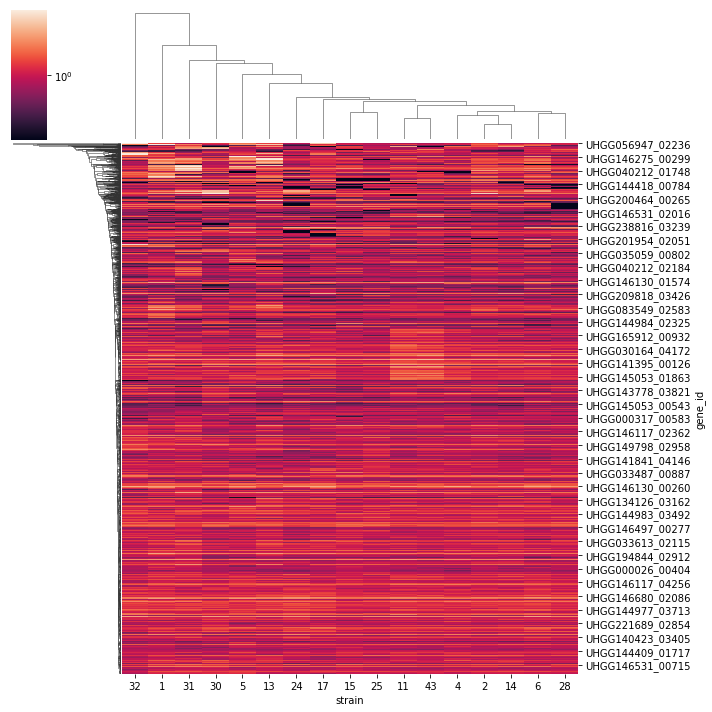

In [44]:
genes_list = idxwhere((depth3_hit.mean(1) > 0.8))
d = strain_depth3.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[genes_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[genes_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[genes_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/Users/byronsmith/.snakemake/conda/2a48d9d4448bc4e9580787d57cf77750/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


12438 4114

tRNA modification                              32
Aromatic amino acid biosynthesis               26
Fatty acid biosynthesis                        26
Glycolysis                                     23
TCA cycle                                      20
Heme biosynthesis                              20
Non-phosphorylated Entner-Doudoroff pathway    19
Arginine biosynthesis                          19
Cobalamine/B12 biosynthesis                    17
Pyruvate oxidation                             17
Name: pathway, dtype: int64

hypothetical protein                           8324
Tyrosine recombinase XerC                        48
Prophage integrase IntA                          33
D-inositol-3-phosphate glycosyltransferase       18
Vitamin B12 import ATP-binding protein BtuD      15
Prophage integrase IntS                          15
putative protein                                 14
DNA-invertase hin                                14
Adaptive-response sensory-kinase SasA      

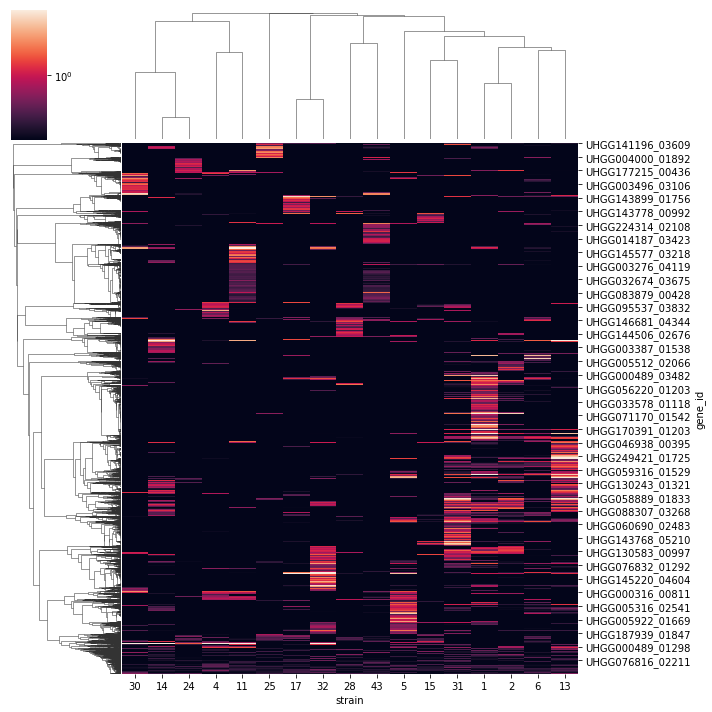

In [45]:
genes_list = idxwhere((depth3_hit.mean(1) > 0.05) & (low_depth3_hit.mean(1) > 0.6))

d = strain_depth3.loc[genes_list]

sns.clustermap(
    d,
    metric='cosine',
    norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.2, vmax=5)
)

print(len(genes_list), len(genes_list) - gene_annotation.loc[genes_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[genes_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[genes_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[genes_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

# Enrichment Analysis in Reference Genomes

In [46]:
reference_meta = pd.read_table('ref_temp/uhgg_genomes_all_4644.tsv', index_col='Genome').rename_axis(index='genome_id')[lambda x: x.MGnify_accession == 'MGYG-HGUT-' + species_id[1:]].rename(lambda s: 'UHGG' + s[10:])
reference_meta.head()

,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,Species_rep,MGnify_accession,Lineage,Continent
genome_id,,,,,,,,,,,
UHGG000026,Isolate,5095388,44,245104,50.56,99.72,0.08,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe
UHGG000027,Isolate,4998207,106,103519,50.65,99.03,0.30,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe
UHGG000036,Isolate,4978086,124,99332,50.65,99.27,0.35,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe
UHGG000309,Isolate,4682102,42,653581,50.65,99.97,0.93,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,North America
UHGG000316,Isolate,5046484,66,244235,50.51,99.67,0.04,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe


In [47]:
with subprocess.Popen(['lz4cat', f'ref_temp/midasdb_uhgg_pangenomes/{species_id}/gene_info.txt.lz4'], stdout=subprocess.PIPE) as f:
    reference_gene = pd.read_table(f.stdout)[['gene_id', 'centroid_75']].assign(genome_id=lambda x: x.gene_id.str.split('_').str[0])[['genome_id', 'centroid_75']].value_counts().unstack('genome_id', fill_value=0)

In [48]:
isolate_gene = reference_gene[idxwhere(reference_meta.Genome_type == 'Isolate')]

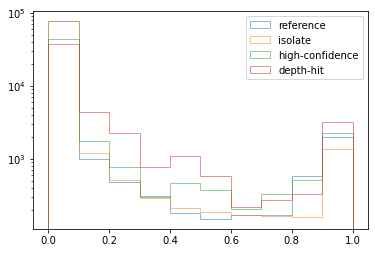

In [49]:
bins = np.linspace(0, 1, num=11)

plt.hist(reference_gene.mean(1), bins=bins, alpha=0.5, label='reference', histtype='step')
plt.hist(isolate_gene.mean(1), bins=bins, alpha=0.5, label='isolate', histtype='step')
# plt.hist(highest_confidence_hit.mean(1), bins=bins, alpha=0.5, label='highest-confidence', histtype='step')
plt.hist(high_confidence_hit.mean(1), bins=bins, alpha=0.5, label='high-confidence', histtype='step')
plt.hist(depth_hit.mean(1), bins=bins, alpha=0.5, label='depth-hit', histtype='step')

plt.yscale('log')
plt.legend()

None

In [50]:
reference_gene.shape

(82169, 8288)

In [51]:
(
    len(set(idxwhere(high_confidence_hit.mean(1) > 0.8)) - set(idxwhere((reference_gene > 0).mean(1) > 0.8))),
    len(set(idxwhere(high_confidence_hit.mean(1) > 0.8)) - set(idxwhere((reference_gene > 0).mean(1) > 0.8))),
)

(267, 267)

In [52]:
(
    len(set(idxwhere((reference_gene > 0).mean(1) > 0.8)) - set(idxwhere(high_confidence_hit.mean(1) > 0.8))),
    len(set(idxwhere((isolate_gene > 0).mean(1) > 0.8)) - set(idxwhere(high_confidence_hit.mean(1) > 0.8))),
)

(433, 600)

(0.8582693820126537, 0.0)


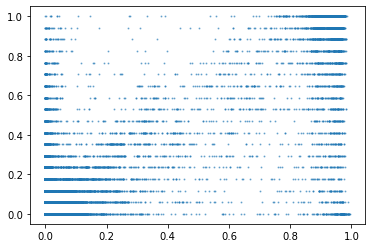

In [53]:
x = (reference_gene > 0).mean(1)
y = highest_confidence_hit.mean(1)

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=False)
y = y.reindex(_all_genes, fill_value=False)


plt.scatter(x, y, s=1, alpha=0.5)
print(sp.stats.pearsonr(x, y))

(0.9352288309368988, 0.0)


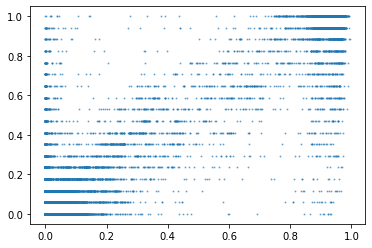

In [54]:
x = (reference_gene > 0).mean(1)
y = high_confidence_hit.mean(1)

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)

plt.scatter(x, y, s=1, alpha=0.5)
print(sp.stats.pearsonr(x, y))

(0.9210779114528593, 0.0)


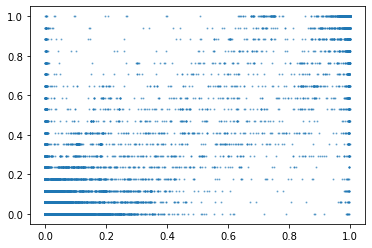

In [55]:
x = (isolate_gene > 0).mean(1)
y = high_confidence_hit.mean(1)

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)

plt.scatter(x, y, s=1, alpha=0.5)
print(sp.stats.pearsonr(x, y))

(0.9243230790586026, 0.0)


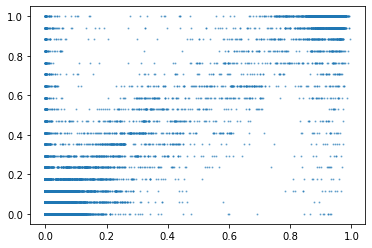

In [56]:
x = (reference_gene > 0).mean(1)
y = medium_confidence_hit.mean(1)

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)


plt.scatter(x, y, s=1, alpha=0.5)
print(sp.stats.pearsonr(x, y))

(0.9092896032106115, 0.0)


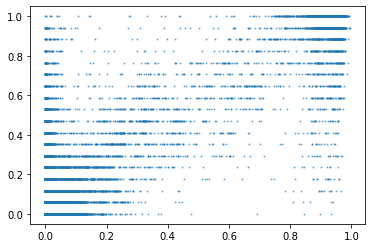

In [57]:
x = (reference_gene > 0).mean(1)
y = corr_hit.mean(1)

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)


plt.scatter(x, y, s=1, alpha=0.5)
print(sp.stats.pearsonr(x, y))

In [58]:
x = (reference_gene > 0).sample(frac=1.0, replace=False, axis='columns')
y = high_confidence_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)

jac_cdist_inf = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

In [59]:
x = (reference_gene > 0).sample(frac=1.0, replace=False, axis='columns')
y = depth_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)

jac_cdist_inf7 = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

In [60]:
x = (reference_gene > 0).sample(frac=1.0, replace=False, axis='columns')
y = depth2_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)

jac_cdist_inf2 = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

In [61]:
x = (reference_gene > 0).sample(frac=1.0, replace=False, axis='columns')
y = depth3_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)


jac_cdist_inf3 = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

In [62]:
x = (reference_gene > 0).sample(frac=1.0, replace=False, axis='columns')
y = medium_confidence_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)

jac_cdist_inf4 = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

In [63]:
x = (reference_gene > 0).sample(frac=1.0, replace=False, axis='columns')
y = highest_confidence_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)

jac_cdist_inf5 = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

In [64]:
x = (reference_gene > 0).sample(frac=1.0, replace=False, axis='columns')
y = corr_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)

jac_cdist_inf6 = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

In [65]:
n = 100

u, v = x.iloc[:, :n], x.iloc[:, n:]
jac_cdist_ref = pd.DataFrame(sp.spatial.distance.cdist(u.T, v.T, metric='jaccard'), index=u.columns, columns=v.columns).T

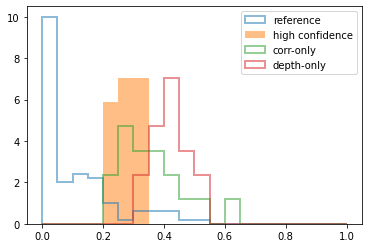

In [66]:
bins = np.linspace(0, 1, num=21)
plt.hist(jac_cdist_ref.min(), bins=bins, alpha=0.5, label='reference', density=True, histtype='step', lw=2)
plt.hist(jac_cdist_inf.min(), bins=bins, alpha=0.5, label='high confidence', density=True, histtype='stepfilled', lw=2)
plt.hist(jac_cdist_inf6.min(), bins=bins, alpha=0.5, label='corr-only', density=True, histtype='step', lw=2)
# plt.hist(jac_cdist_inf4.min(), bins=bins, alpha=0.5, label='medium confidence', density=True, histtype='step', lw=2)
# plt.hist(jac_cdist_inf2.min(), bins=bins, alpha=0.5, label='depth-only-2', density=True, histtype='step', lw=2)
plt.hist(jac_cdist_inf7.min(), bins=bins, alpha=0.5, label='depth-only', density=True, histtype='step', lw=2)
# plt.hist(jac_cdist_inf3.min(), bins=bins, alpha=0.5, label='depth-only-3', density=True, histtype='step', lw=2)
# plt.hist(jac_cdist_inf5.min(), bins=bins, alpha=0.5, label='highest confidence', density=True, histtype='step', lw=2)

plt.legend()

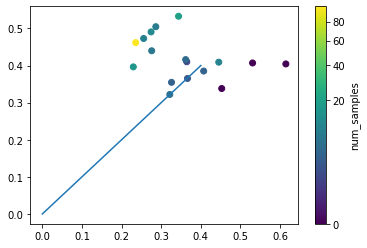

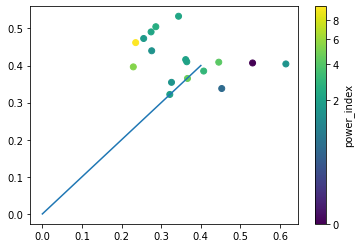

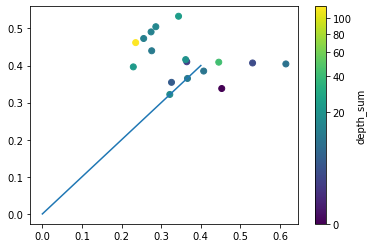

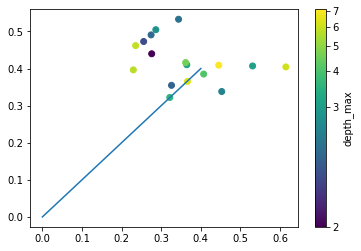

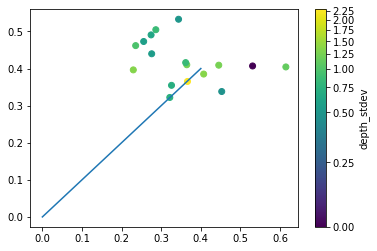

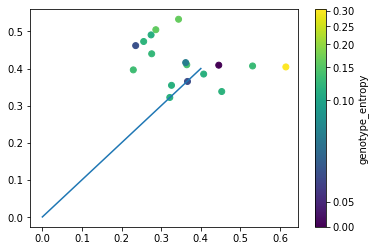

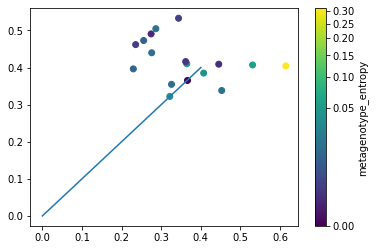

In [67]:
d = pd.DataFrame(dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    depth_hit_min_dist=jac_cdist_inf7.min(),
    high_corr_min_dist=jac_cdist_inf6.min(),
    med_conf_hit_min_dist=jac_cdist_inf4.min(),
)).join(strain_meta)

for c in ['num_samples', 'power_index', 'depth_sum', 'depth_max', 'depth_stdev', 'genotype_entropy', 'metagenotype_entropy']:
    plt.figure()
    plt.scatter('high_corr_min_dist', 'depth_hit_min_dist', data=d, c=c, norm=mpl.colors.PowerNorm(1/3))
    plt.colorbar(label=c)
    plt.plot([0, 0.4], [0, 0.4])

SpearmanrResult(correlation=-0.773205863823077, pvalue=0.00027252625640640136)

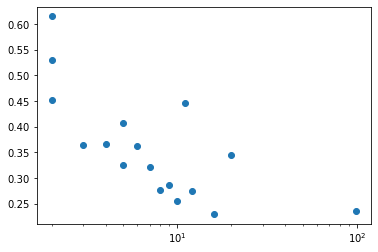

In [68]:
d = pd.DataFrame(dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    depth_hit_min_dist=jac_cdist_inf7.min(),
    high_corr_min_dist=jac_cdist_inf6.min(),
    med_conf_hit_min_dist=jac_cdist_inf4.min(),
)).join(strain_meta)

    
plt.figure()
plt.scatter(d['num_samples'], d['high_corr_min_dist'])
plt.xscale('log')
sp.stats.spearmanr(d['num_samples'], d['high_corr_min_dist'])

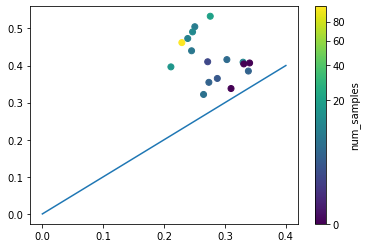

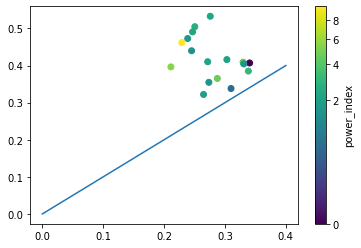

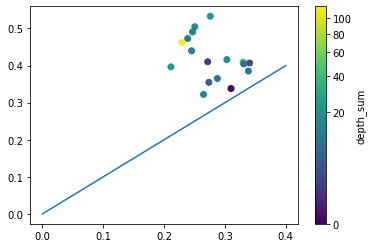

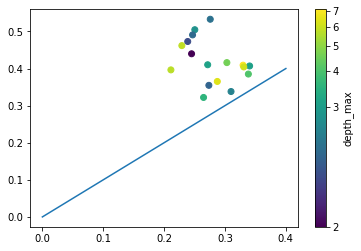

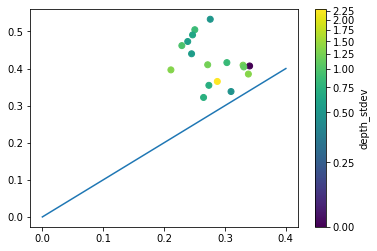

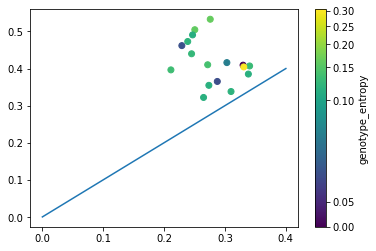

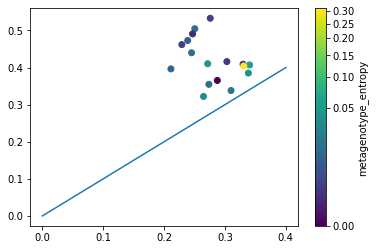

In [69]:
d = pd.DataFrame(dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    depth_hit_min_dist=jac_cdist_inf7.min(),
    high_corr_min_dist=jac_cdist_inf6.min(),
    med_conf_hit_min_dist=jac_cdist_inf4.min(),
)).join(strain_meta)

for c in ['num_samples', 'power_index', 'depth_sum', 'depth_max', 'depth_stdev', 'genotype_entropy', 'metagenotype_entropy']:
    plt.figure()
    plt.scatter('conf_hit_min_dist', 'depth_hit_min_dist', data=d, c=c, norm=mpl.colors.PowerNorm(1/3))
    plt.colorbar(label=c)
    plt.plot([0, 0.4], [0, 0.4])

In [70]:
x = reference_gene > 0
y = high_confidence_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=0)
y = y.reindex(_all_genes, fill_value=0)

cdist = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

diff = pd.DataFrame(x[cdist.idxmin()].values * 2 - y[cdist.columns].values * 3, index=x.index, columns=y.columns).replace({-3: 'only_inf', -1: 'shared_genes', 0: 'both_lacking', 2: 'only_ref'})
diff.apply(lambda x: x.value_counts())

,1,2,4,5,6,11,13,14,15,17,24,25,28,30,31,32,43
both_lacking,77622,77726,77172,77428,77984,76934,77336,77703,76970,77415,77452,77809,77276,76971,77399,76703,77209
only_inf,703,301,970,544,424,813,602,428,1268,676,743,818,967,1154,619,1065,1199
only_ref,551,717,721,618,624,913,552,515,502,615,506,435,516,457,558,430,442
shared_genes,3293,3425,3306,3579,3137,3509,3679,3523,3429,3463,3468,3107,3410,3587,3593,3971,3319


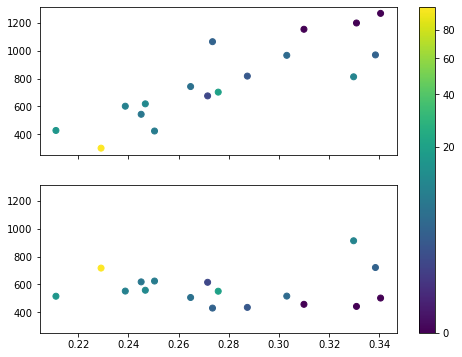

In [71]:
d = strain_meta.join(diff.apply(lambda x: x.value_counts()).T).assign(**dict(
    conf_hit_min_dist=jac_cdist_inf.min(),
    depth_hit_min_dist=jac_cdist_inf7.min(),
    high_corr_min_dist=jac_cdist_inf6.min(),
    med_conf_hit_min_dist=jac_cdist_inf4.min(),
))

# d = strain_meta.join(diff.apply(lambda x: x.value_counts()).T)

fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(8, 6))

mappable = axs[0].scatter('conf_hit_min_dist', 'only_inf', data=d, c='num_samples', norm=mpl.colors.PowerNorm(1/3))
mappable = axs[1].scatter('conf_hit_min_dist', 'only_ref', data=d, c='num_samples', norm=mpl.colors.PowerNorm(1/3))
plt.colorbar(mappable, ax=axs)
# axs[1].set_xscale('log')

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00035294, 0.00035294, 0.00047059, 0.00011765, 0.00047059,
        0.00011765, 0.00011765, 0.        , 0.        , 0.        ]),
 array([    0.,   500.,  1000.,  1500.,  2000.,  2500.,  3000.,  3500.,
         4000.,  4500.,  5000.,  5500.,  6000.,  6500.,  7000.,  7500.,
         8000.,  8500.,  9000.,  9500., 10000.]),
 [<matplotlib.patches.Polygon at 0x1554a3a60>])

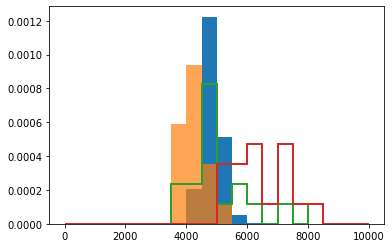

In [72]:
bins = np.linspace(0, 1e4, num=21)

# plt.hist(reference_gene.sum(), density=True, bins=bins)
plt.hist(isolate_gene.sum(), density=True, bins=bins, label='isolate')
plt.hist(high_confidence_hit.sum(), density=True, bins=bins, alpha=0.7, label='high-confidence')
# plt.hist(medium_confidence_hit.sum(), density=True, alpha=0.5, bins=bins)
plt.hist(corr_hit.sum(), density=True, bins=bins, histtype='step', lw=2, label='corr-only')
plt.hist(depth_hit.sum(), density=True, bins=bins, histtype='step', lw=2, label='depth-only')